In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from pathlib import Path

from yes_i_hate_it.gather_tweets import Tweet
from yes_i_hate_it.config import TWEETS_DB_PATH

read dataset

In [2]:
data_path = Path('../../')/TWEETS_DB_PATH
data_path

PosixPath('../../data/tweets.sqlite')

In [3]:
engine = create_engine(f'sqlite:///{data_path}')
session_maker = sessionmaker(bind=engine)
session = session_maker()
tweets = session.query(Tweet).filter(Tweet.processed==False).all()
print(type(tweets))

<class 'list'>


In [4]:
from yes_i_hate_it.generate_bow import process_text

d = {'text': [tweet.text for tweet in tweets],
     'is_football': [1 if tweet.is_football else 0 for tweet in tweets]}

data = pd.DataFrame(d)

data

[nltk_data] Downloading package stopwords to /home/inigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,is_football
0,RT @LaLiga: 2015/16 🏆👊\n2016/17 🏆👊\n2017/18 🏆👊...,1
1,RT @Atleti: La familia atlética está de luto. ...,1
2,El fichaje de Mario Hermoso se congela.\n\nAl ...,1
3,"#FernandoTorres: ""No se a quién echarán más de...",1
4,James Rodríguez esperaría al Atlético.\n\nEl j...,1
...,...,...
11140,"RT @ESLspain: #ENDIRECTO 🖥\n🔴 Estamos ON, en l...",0
11141,"RT @Boltz: Gg 9-16 vs Furia, n entrei no game ...",0
11142,"RT @Yusef210: Vamos con el ultimo Bo1 del día,...",0
11143,¡Felicidades a todo el equipo de @hora25! \n\n...,0


In [5]:
import nltk
nltk.download('stopwords')

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer("spanish",ignore_stopwords=True)

preprocessed_text = []
for i in data.text:
    tokens = [stemmer.stem(word) for word in tokenizer.tokenize(i.lower())]
    preprocessed_text.append(np.array(' '.join(tokens)))
    
data['pp_text'] = preprocessed_text
data['pp_text'] = data['pp_text'].astype('str')
print(type(data['pp_text'][0]))
data['n_words'] = data['pp_text'].str.split().apply(len)

data = data.sample(frac=1).reset_index(drop=True)

data.head()

[nltk_data] Downloading package stopwords to /home/inigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'str'>


,text,is_football,pp_text,n_words
0,"Mi capitán, mi eterno 14. https://t.co/WaRn7T5BKR",1,mi capitan mi etern 14 https t co warn7t5bkr,9
1,El Real de Madrid se ha llevado un partido sin...,1,el real de madr se ha llev un part sin hac abs...,17
2,RT @LaLiga: ⚽🌟 #CeltaRealMadrid\n\n🎙 @sergiog0...,0,rt lalig celtarealmadr sergiog0tt y alexgutnav...,12
3,Procedo a ver Star Wars: La venganza de los Si...,0,proced a ver star wars la venganz de los sith ...,25
4,RT @Atleti: 𝗥𝗧 si ❤ a este chico. https://t.co...,1,rt atleti 𝗥𝗧 si a este chic https t co uont7bwp7n,11


<AxesSubplot:>

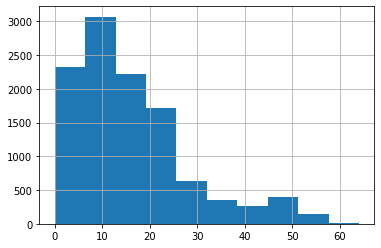

In [6]:
data['n_words'].hist()

In [7]:
from tensorflow.keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(data['pp_text'])


In [8]:
def generator(data, size):
    idx = 0
    
    while True:
        data_nxt = data.iloc[idx:idx+size]
        max_len = data_nxt['n_words'].max()+1
        
        x_batch = preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(data_nxt['pp_text']), max_len)
        y_batch = data_nxt['is_football'].values
        
        yield x_batch, y_batch
        
        idx = (idx + size) % len(data)

In [9]:
from tensorflow.keras import Sequential, layers

max_features = 1+len(tokenizer.word_index)
embedding_dims = 100
N = 128


model = Sequential(
    [
        layers.InputLayer((None,)),
        layers.Embedding(input_dim=max_features, output_dim=embedding_dims),
        layers.Dropout(0.2),
        layers.LSTM(units=N, return_sequences=True),
        layers.LSTM(units=N, return_sequences=True),
        layers.LSTM(units=N, return_sequences=True),
        layers.LSTM(units=N),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

2022-07-22 20:51:14.167131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 20:51:14.247995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-07-22 20:51:14.248020: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-22 20:51:14.249648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [10]:
n = int(len(data)*0.9)

data_train = data.iloc[:n].copy()
data_test = data.iloc[n:].copy()

In [11]:
data_train['pp_text']

0             mi capitan mi etern 14 https t co warn7t5bkr
1        el real de madr se ha llev un part sin hac abs...
2        rt lalig celtarealmadr sergiog0tt y alexgutnav...
3        proced a ver star wars la venganz de los sith ...
4        rt atleti 𝗥𝗧 si a este chic https t co uont7bwp7n
                               ...                        
10025    porciert la ultim jug que el porter del sevill...
10026    nacho8gonz escuch que ha sid peticion expres d...
10027    europ deb defend a su ciudadan no pued ser un ...
10028    gallegohumbert no cre que exist un maltrat al ...
10029    atletimedi awards rewind 2021 con peñit del at...
Name: pp_text, Length: 10030, dtype: object

In [12]:
gen_train = generator(data_train, 32)
gen_val = generator(data_train, 32)

history = model.fit(
    gen_train,
    steps_per_epoch = len(data_train) // 32,
    epochs = 25,
    validation_data = gen_val,
    validation_steps = 4,
    batch_size = 32
)

Epoch 1/25
313/313 [==============================] - 32s 88ms/step - loss: 0.3782 - val_loss: 0.2879
Epoch 2/25
313/313 [==============================] - 27s 85ms/step - loss: 0.1914 - val_loss: 0.1302
Epoch 3/25
313/313 [==============================] - 31s 98ms/step - loss: 0.1078 - val_loss: 0.0861
Epoch 4/25
313/313 [==============================] - 30s 95ms/step - loss: 0.0692 - val_loss: 0.0068
Epoch 5/25
313/313 [==============================] - 30s 97ms/step - loss: 0.0488 - val_loss: 0.0924
Epoch 6/25
313/313 [==============================] - 30s 97ms/step - loss: 0.0323 - val_loss: 0.0031
Epoch 7/25
313/313 [==============================] - 31s 98ms/step - loss: 0.0293 - val_loss: 0.0186
Epoch 8/25
313/313 [==============================] - 31s 98ms/step - loss: 0.0292 - val_loss: 0.0429
Epoch 9/25
313/313 [==============================] - 31s 99ms/step - loss: 0.0291 - val_loss: 0.0403
Epoch 10/25
313/313 [==============================] - 33s 107ms/step - loss: 0.02

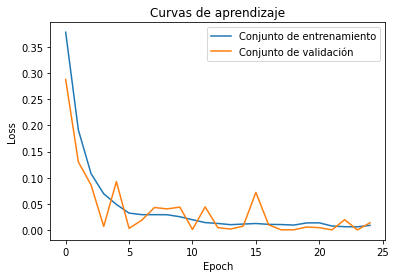

In [13]:
import matplotlib.pyplot as plt

def plot_learning_curves(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Curvas de aprendizaje')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')  
    plt.legend(['Conjunto de entrenamiento', 'Conjunto de validación'], loc='upper right')
    plt.show()

plot_learning_curves(history)

In [14]:
import sklearn
import numpy as np

gen_test = generator(data_test, 32)

y_test = []
y_pred = []
x_test_batch, y_test_batch = next(gen_test)
model.predict(x_test_batch)

for _ in range(len(data_test) // 32):
    x_test_batch, y_test_batch = next(gen_test)
    y_pred_batch = np.clip(model.predict(x_test_batch), 0, 1)
    y_test += list(y_test_batch)
    y_pred += list(y_pred_batch)

print(f"test {sklearn.metrics.f1_score(y_test, y_pred)}")

1/1 [==============================] - 1s 1s/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
def predict(text, tokenizer):
    length = len(text.split(' '))
    x = preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(text), length)
    predict = np.clip(model.predict(x), 0, 1)
    print(predict)
    return 0

print(predict('viva el futbol, fernando torres y el atleti', tokenizer))